In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchcfm import optimal_transport as OT
import torchdiffeq
from torchdiffeq import odeint
import torchsde
import torchdyn
from torchdyn.core import NeuralODE


# Set random seed for reproducibility
torch.manual_seed(314)
np.random.seed(314)

In [2]:
def sample_prior(batch_size: int, low: float = 0., high: float = np.pi, device: torch.device = torch.device('cpu')) -> torch.Tensor:
    """
    Sample from the prior distribution p(theta).
    By default, uses a uniform distribution over [low, high] for each dimension.
    
    Parameters
    ----------
    batch_size : int
        Number of samples to generate.
    low : float, optional
        Lower bound of the uniform distribution. Default is -5.0.
    high : float, optional
        Upper bound of the uniform distribution. Default is 5.0.
    device : torch.device, optional
        Device to place the sampled tensor. Default is CPU.
    
    Returns
    -------
    theta : Tensor, shape (batch_size, 2)
        Sampled parameters.
    """
    return torch.rand(batch_size, 1, device=device) * (high - low) + low  # Uniformly sampled from [low, high]

def sample_conditional_pt(theta: torch.Tensor, x_obs: torch.Tensor, t: torch.Tensor, sigma: float) -> torch.Tensor:
    """
    Draw a sample from the conditional probability path N(mu_t, sigma),
    where mu_t = t * x_obs + (1 - t) * theta.
    
    Parameters
    ----------
    theta : Tensor, shape (batch_size, 2)
        Represents the source parameter samples.
    x_obs : Tensor, shape (batch_size, 2)
        Represents the observed data samples.
    t : Tensor, shape (batch_size, 1)
        Time steps sampled uniformly from [0, 1].
    sigma : float
        Standard deviation of the Gaussian noise.
    
    Returns
    -------
    theta_t : Tensor, shape (batch_size, 2)
        Sampled points along the probability path.
    """
    mu_t = t * x_obs + (1 - t) * theta  # Linear interpolation between theta and x_obs
    epsilon = torch.randn_like(theta)    # Gaussian noise
    theta_t = mu_t + sigma * epsilon    # Sampled points with noise
    return theta_t

def compute_conditional_vector_field(theta: torch.Tensor, x_obs: torch.Tensor) -> torch.Tensor:
    """
    Compute the conditional vector field u_t(theta | z).
    For Gaussian paths with mu_t = t * x_obs + (1 - t) * theta and sigma_t = sigma,
    the vector field simplifies to (x_obs - theta).
    
    Parameters
    ----------
    theta : Tensor, shape (batch_size, 2)
        Source parameter samples.
    x_obs : Tensor, shape (batch_size, 2)
        Observed data samples.
    
    Returns
    -------
    u_t : Tensor, shape (batch_size, 2)
        Conditional vector field.
    """
    return x_obs - theta


In [37]:
class MLP(nn.Module):
    def __init__(self, dim: int, dim_cond: int = 0, time_varying: bool = True):
        """
        Initialize the MLP model.

        Parameters
        ----------
        dim : int
            Dimensionality of the state space.
        dim_cond : int, optional
            Dimensionality of the conditional input. Default is 0 (no conditional input).
        time_varying : bool, optional
            If True, the model takes time t as an additional input. Default is True.
        """
        super(MLP, self).__init__()
        self.time_varying = time_varying
        self.dim_cond = dim_cond
        input_dim = dim + 1 + dim_cond if time_varying else dim + dim_cond  # +1 for time if time_varying

        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), 
            nn.ReLU(),                
            nn.Linear(256, 256),
            nn.ReLU(),                
            nn.Linear(256, 512),
            nn.ReLU(),                
            nn.Linear(512, 512),
            nn.ReLU(),                
            nn.Linear(512, 256),
            nn.ReLU(),  
            nn.Linear(256, dim)
        )

    def forward(self, t: torch.Tensor, x: torch.Tensor, x_cond: torch.Tensor = None) -> torch.Tensor:
        """
        Forward pass of the MLP.

        Parameters
        ----------
        t : Tensor, shape (batch_size, 1)
            Time tensor.
        x : Tensor, shape (batch_size, dim)
            State tensor.
        x_cond : Tensor, shape (batch_size, dim_cond), optional
            Conditional input tensor.

        Returns
        -------
        v : Tensor, shape (batch_size, dim)
            Vector field output.
        """
        if self.time_varying:
            # Ensure t is of shape (batch_size, 1)
            if t.dim() == 0:
                t = t.unsqueeze(0).repeat(x.size(0), 1)
            elif t.dim() == 1:
                t = t.unsqueeze(1)

            if self.dim_cond > 0 and x_cond is not None:
                input = torch.cat([t, x, x_cond], dim=-1)
            else:
                input = torch.cat([t, x], dim=-1)
        else:
            if self.dim_cond > 0 and x_cond is not None:
                input = torch.cat([x, x_cond], dim=-1)
            else:
                input = x

        v = self.net(input)
        return v

    def log_p_base(self, x: torch.Tensor, reduction: str = 'none') -> torch.Tensor:
        """
        Compute the log-probability of `x` under a standard normal distribution.

        Parameters
        ----------
        x : Tensor, shape (batch_size, dim)
            Input tensor.
        reduction : str, optional
            Reduction method: 'none' | 'mean' | 'sum'. Default is 'none'.

        Returns
        -------
        log_prob : Tensor, shape [batch_size]
            Log probabilities.
        """
        base_dist = torch.distributions.Normal(loc=torch.zeros_like(x), scale=torch.ones_like(x))
        base_dist = torch.distributions.Uniform(low=0. * torch.ones_like(x), high=np.pi * torch.ones_like(x))
        log_prob = base_dist.log_prob(x).sum(dim=1)  # Sum over dimensions

        if reduction == 'sum':
            return log_prob.sum()
        elif reduction == 'mean':
            return log_prob.mean()
        else:
            return log_prob  # Shape: [batch_size]

    def log_prob_flow(self, x_1: torch.Tensor, x_cond: torch.Tensor, reduction: str = 'mean') -> torch.Tensor:
        """
        Compute the log-likelihood of the data `x_1` under the learned flow.
        This method uses the backward Euler approximation.

        Parameters
        ----------
        x_1 : Tensor, shape (batch_size, dim)
            The real data at time t=1.
        x_cond : Tensor, shape (batch_size, dim_cond)
            The conditional input.
        reduction : str, optional
            Reduction method: 'none' | 'mean' | 'sum'. Default is 'mean'.

        Returns
        -------
        log_prob : Tensor
            Log-probabilities.
        """
        T = 100  # Number of time steps
        ts = torch.linspace(1., 0., T, device=x_1.device)
        delta_t = ts[1] - ts[0]

        # Initialize
        x_t = x_1.clone()  # Start from the final state at time t=1
        f_t = torch.zeros(x_t.shape[0], device=x_t.device)  # Initialize log determinant correction term

        for idx, t in enumerate(ts):
            if idx == 0:  # First step (t=1)
                continue  # No update needed at t=1
            else:
                # Compute the vector field (v_t) at time `t`
                v_t = self.forward(t, x_t, x_cond=x_cond)  # Updated forward call

                # Update x_t (Backward Euler step)
                x_t = x_t - v_t * delta_t

                # Approximate the divergence using Hutchinson's trace estimator
                x_t_copy = x_t.clone().detach().requires_grad_(True)
                e = torch.randn_like(x_t_copy)  # Random vector for trace estimation

                # Compute the vector field for gradient computation
                v_t_copy = self.forward(t, x_t_copy, x_cond=x_cond)

                # Sum the outputs to compute gradients
                v_t_sum = v_t_copy.sum()

                # Compute gradients
                v_t_grad = torch.autograd.grad(outputs=v_t_sum, inputs=x_t_copy, create_graph=True)[0]

                # Estimate the trace (divergence)
                trace_estimate = (v_t_grad * e).view(x_t.shape[0], -1).sum(dim=1)  # Shape: [batch_size]

                # Accumulate the correction term
                f_t += trace_estimate * delta_t

        # Compute the log-probability at t=0 using the base distribution
        if not torch.all((x_t >= -5.0) & (x_t <= 5.0)):
            print("Out-of-bounds values detected in tensor, clamping x_t!")
            print(f"{np.sum(not torch.all((x_t >= -5.0) & (x_t <= 5.0)))} values out of bounds.")
            x_t = torch.clamp(x_t, min=-5.0, max=5.0)


        log_p_0 = self.log_p_base(x_t, reduction='none')  # Shape: [batch_size]

        # Final log-probability
        log_prob = log_p_0 - f_t  # Shape: [batch_size]

        if reduction == 'mean':
            return log_prob.mean()
        elif reduction == 'sum':
            return log_prob.sum()
        else:
            return log_prob  # Shape: [batch_size]


In [33]:
class ConditionalFlowMatcher(nn.Module):
    def __init__(self, sigma: float):
        """
        Initialize the Conditional Flow Matcher.
        
        Parameters
        ----------
        sigma : float
            Standard deviation of the noise in the conditional probability path.
        """
        super(ConditionalFlowMatcher, self).__init__()
        self.sigma = sigma
        self.loss_fn = nn.MSELoss()

    def forward(self, vt: torch.Tensor, ut: torch.Tensor) -> torch.Tensor:
        """
        Compute the Conditional Flow Matching (CFM) loss.
        
        Parameters
        ----------
        vt : Tensor, shape (batch_size, 2)
            Predicted vector field by the model.
        ut : Tensor, shape (batch_size, 2)
            True conditional vector field.
        
        Returns
        -------
        loss : Tensor
            Computed CFM loss.
        """
        return self.loss_fn(vt, ut)


In [34]:
def get_ode_func(model, x_cond):
    """
    Returns a function suitable for torchdiffeq's odeint that incorporates x_cond.

    Parameters
    ----------
    model : nn.Module
        The MLP model representing the vector field.
    x_cond : Tensor, shape (batch_size, dim_cond)
        The conditional input tensor.

    Returns
    -------
    func : callable
        Function that takes time `t` and state `x` and returns the vector field.
    """
    def func(t, x):
        # If x is 1D, add a batch dimension
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        # Create a tensor of t with shape [batch_size, 1]
        t_batch = t * torch.ones(x.size(0), 1, device=x.device)
        
        return model(t_batch, x, x_cond)
    
    return func


In [22]:
def plot_posterior(theta_samples: torch.Tensor, theta_true: torch.Tensor):
    """
    Plot the inferred posterior samples alongside the true parameter.

    Parameters
    ----------
    theta_samples : Tensor, shape (num_samples, 2)
        Samples from the inferred posterior distribution.
    theta_true : Tensor, shape (1, 2)
        The true parameter value.
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(theta_samples[:, 0].cpu().numpy(), theta_samples[:, 1].cpu().numpy(), alpha=0.3, label='Inferred Posterior')
    plt.scatter(theta_true[:, 0].cpu().numpy(), theta_true[:, 1].cpu().numpy(), color='red', label='True Parameter', marker='x', s=100)
    plt.title("Inferred Posterior Distribution")
    plt.xlabel("$\\theta_1$")
    plt.ylabel("$\\theta_2$")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
dataset_dir = './dataset/FM_dataset.pkl'
data = pd.read_pickle(dataset_dir)
print(data.head())
print(data.shape)

,zenith,azimuth,event_no,energy,latent_vec
0,2.287569,4.252627,23.0,944.297598,"[0.0, 0.0, 0.0, 0.0, 122.22716, 0.0, 0.0, 0.0,..."
1,2.081253,4.374673,27.0,1678.264241,"[0.0, 0.0, 0.0, 0.0, 62.239994, 0.0, 0.0, 0.0,..."
2,2.738480,2.118246,31.0,24595.207684,"[0.0, 114.393036, 0.0, 0.0, 328.88135, 0.0, 0...."
3,2.252435,2.653680,36.0,124.191728,"[0.0, 10.383446, 0.0, 0.0, 62.476994, 0.0, 0.0..."
4,2.033719,1.189017,52.0,231.562639,"[0.0, 0.0, 0.0, 0.0, 18.572924, 0.0, 0.0, 18.2..."
5,1.798425,4.891208,61.0,150655.575456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,2.324498,3.327644,67.0,2261.386977,"[0.0, 0.0, 0.0, 0.0, 109.80789, 0.0, 0.0, 33.5..."
7,2.024780,2.614286,70.0,440.799425,"[0.0, 43.793243, 0.0, 0.0, 28.228018, 0.0, 0.0..."
8,2.791741,4.727921,78.0,19144.041184,"[0.0, 0.0, 0.0, 0.0, 271.38086, 0.0, 0.0, 0.0,..."
9,1.899448,3.283562,83.0,3174.633571,"[0.0, 13.20898, 0.0, 0.0, 18.33173, 0.0, 0.0, ..."


In [54]:
device = 'cuda:0'

# Initialize the Optimal Transport (OT) Plan Sampler with the 'exact' method
ot_sampler = OT.OTPlanSampler(method="exact")

# Set the std for the Gaussian noise added during sampling
sigma = 0.1
dim = 1
batch_size = 1024

# Initialize the model
model = MLP(dim=dim, dim_cond=128, time_varying=True).to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3, eps=1e-6)


# Initialize the Conditional Flow Matcher with the specified sigma
FM = ConditionalFlowMatcher(sigma=sigma).to(device)
#Or one can use the predefined function
#FM = ConditionalFlowMatcher(sigma=sigma).to(device)


# Define the true parameter and generate observed data (ensure x_obs has at least 1024 samples)
theta_true = torch.tensor([[1.0, -1.0]], device=device)  # True parameter (batch_size=1, dim=2)
num_observed_samples = 1024  
theta_true = torch.tensor(data['zenith'][:num_observed_samples], device=device).view(-1,1)  # True parameter (batch_size=1, dim=2)

# Increase the number of observed samples to match the training loop requirement

x_obs = torch.tensor(data['latent_vec'][:num_observed_samples]).to(device)  # Unique samples for each observation


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]


Iteration 0: CFM Loss = 0.9308, Time Elapsed = 0.14 seconds


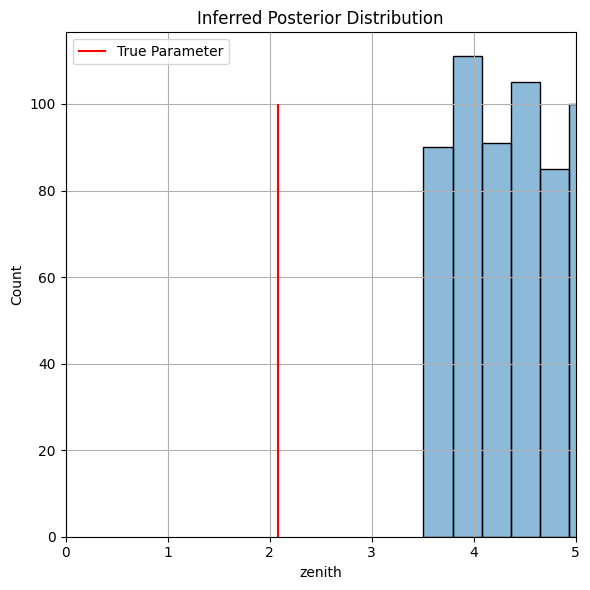

Training Progress:  10%|█         | 100/1000 [00:14<02:06,  7.12it/s]


Iteration 100: CFM Loss = 0.2179, Time Elapsed = 14.34 seconds


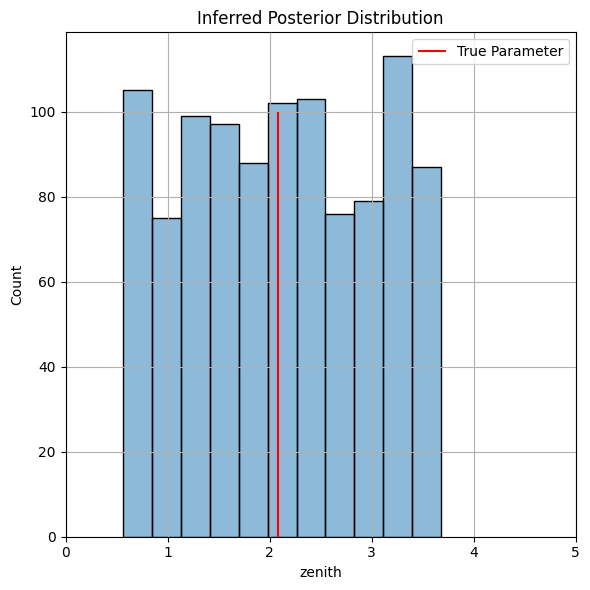

Training Progress:  20%|██        | 200/1000 [00:28<01:53,  7.06it/s]


Iteration 200: CFM Loss = 0.2028, Time Elapsed = 14.31 seconds


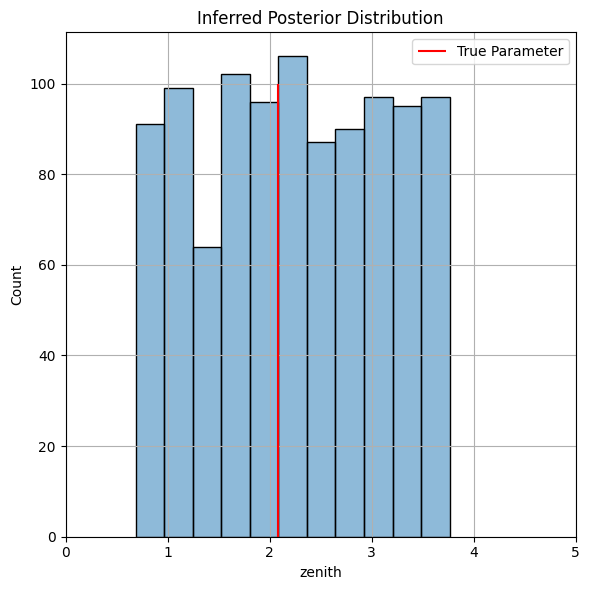

Training Progress:  30%|███       | 300/1000 [00:42<01:37,  7.18it/s]


Iteration 300: CFM Loss = 0.1134, Time Elapsed = 14.17 seconds


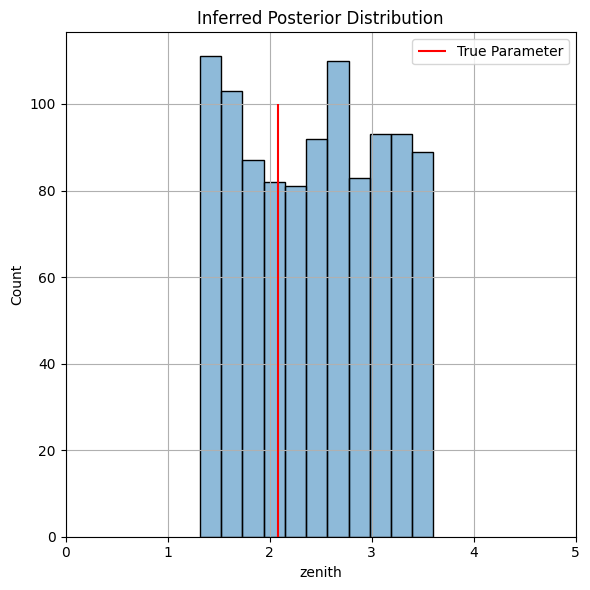

Training Progress:  40%|████      | 400/1000 [00:57<01:24,  7.08it/s]


Iteration 400: CFM Loss = 0.1164, Time Elapsed = 14.25 seconds


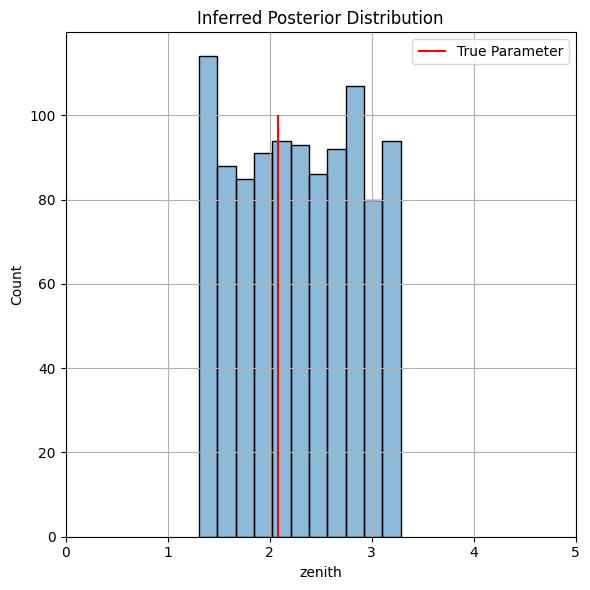

Training Progress:  50%|█████     | 500/1000 [01:11<01:10,  7.10it/s]


Iteration 500: CFM Loss = 0.1047, Time Elapsed = 14.30 seconds


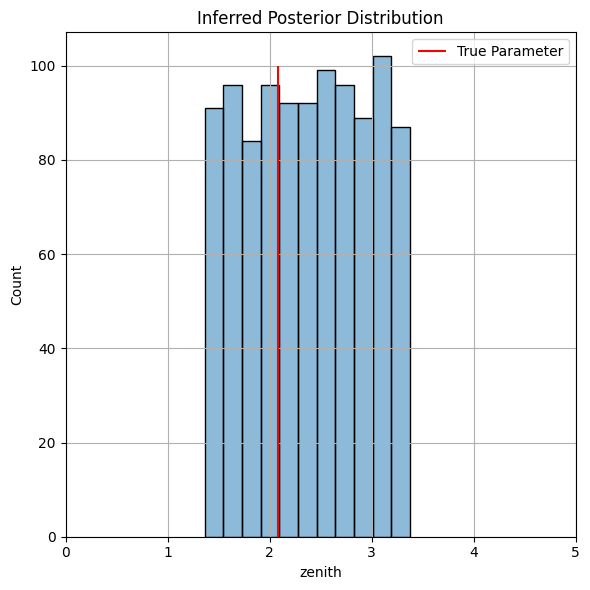

Training Progress:  60%|██████    | 600/1000 [01:25<00:56,  7.06it/s]


Iteration 600: CFM Loss = 0.0555, Time Elapsed = 14.24 seconds


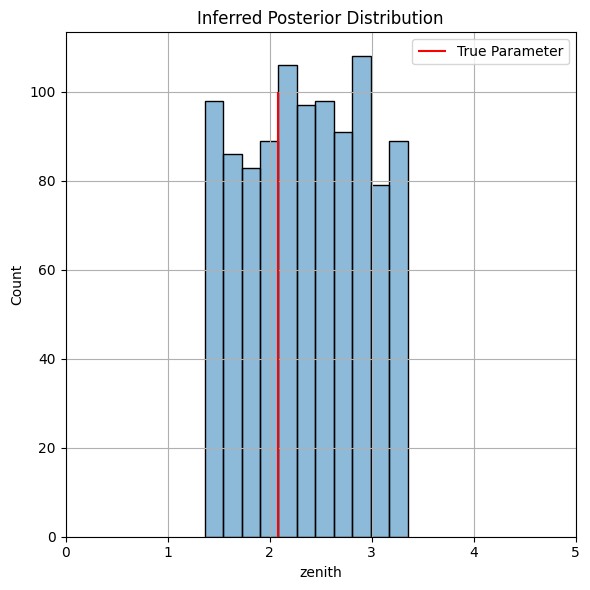

Training Progress:  70%|███████   | 700/1000 [01:39<00:42,  7.13it/s]


Iteration 700: CFM Loss = 0.0628, Time Elapsed = 14.16 seconds


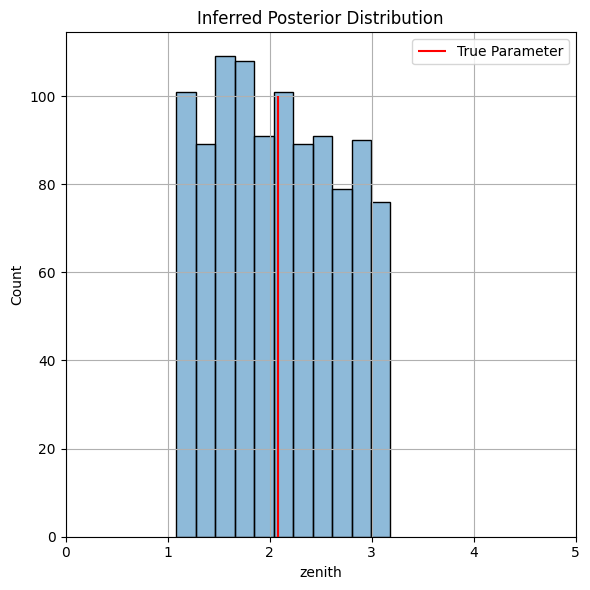

Training Progress:  80%|████████  | 800/1000 [01:54<00:28,  7.07it/s]


Iteration 800: CFM Loss = 0.0668, Time Elapsed = 14.27 seconds


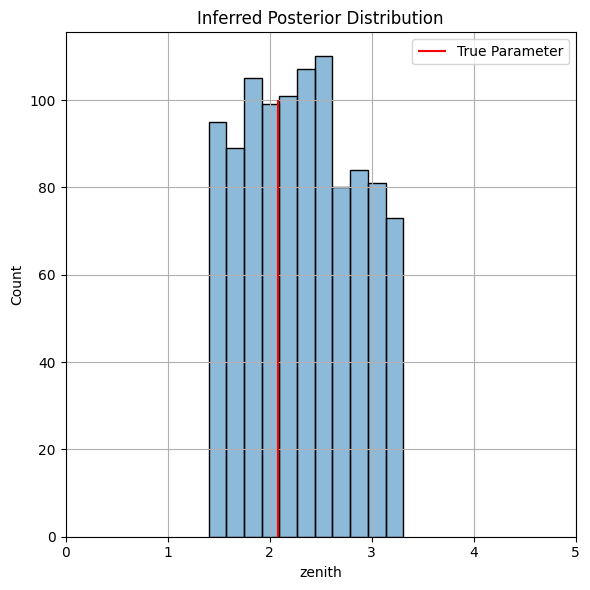

Training Progress:  90%|█████████ | 900/1000 [02:08<00:13,  7.21it/s]


Iteration 900: CFM Loss = 0.0321, Time Elapsed = 14.16 seconds


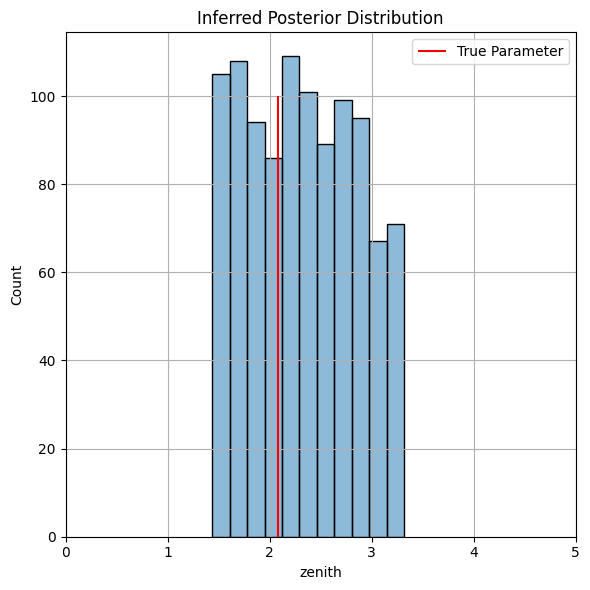

Training Progress: 100%|██████████| 1000/1000 [02:22<00:00,  7.02it/s]


In [ ]:
import seaborn as sns
start_time = time.time()
num_iterations = 1000
log_interval = 100

log_likelihoods_pred = []
log_likelihoods_true = []

for k in tqdm(range(num_iterations), desc="Training Progress"):
    optimizer.zero_grad()
    
    # Sample from the prior distribution p(theta)
    theta0 = sample_prior(batch_size, device=device).float()  # Shape: [batch_size, 2]
    theta1 = theta_true[:batch_size].float()  # Shape: [batch_size, 2]
    
    # Sample observed data 
    x1 = x_obs[:batch_size]  # Shape: [batch_size, 2]
    # Draw samples from the Optimal Transport (OT) plan to pair theta0 with x1
    theta0, theta1 = ot_sampler.sample_plan(theta0, theta1)
    theta0, x1, theta1 = theta0.to(device), x1.to(device), theta1.to(device) 
    
    # Sample random time steps uniformly from [0, 1]
    t_random = torch.rand(theta0.shape[0], 1, device=device)  # Shape: [batch_size, 1]


    
    # Generate intermediate samples along the conditional probability path p_t(theta | z)
    theta_t = sample_conditional_pt(theta0, theta1, t_random, sigma=0.01)  # Shape: [batch_size, 2]
    
    # Compute the true conditional vector field u_t(theta | z)
    ut = compute_conditional_vector_field(theta0, theta1)  # Shape: [batch_size, 2]
    
    # Predict the vector field v_theta(t, theta_t) using the MLP model
    vt = model(t_random, theta_t, x_cond=x1)  # Shape: [batch_size, 2]
    
    # Compute the Conditional Flow Matching loss
    loss_cfm = FM(vt, ut)
    
    # Define the total loss
    loss = loss_cfm
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    
    if k % log_interval == 0:
        current_time = time.time()
        elapsed = current_time - start_time
        print(f"\nIteration {k}: CFM Loss = {loss_cfm.item():.4f}, Time Elapsed = {elapsed:.2f} seconds")
        start_time = current_time
        
        with torch.enable_grad(): 
            # ----------------------------
            # 1. Posterior Contour Plot
            # ----------------------------
            # Sample new parameters from the prior for transformation
            event_id = 1
            theta_samples_prior = sample_prior(1024, device=device)  # Shape: [1024, 1]
            
            # Generate observed data for the posterior samples
            # For simplicity, we'll pair each prior sample with a corresponding x_obs
            # Ensure x_obs has at least 1024 samples
            if x_obs.size(0) < 1024:
                raise ValueError("x_obs does not have enough samples for posterior transformation.")
            x1_posterior = x_obs[:1024]  # Shape: [1024, 1]
            
            # Define time steps for ODE solver (from t=1 to t=0) and Define the ODE function
            t_ode = torch.linspace(0., 1., 100, device=device)
            x1_posterior = torch.ones_like(x1_posterior)*x1_posterior[event_id]
            ode_func = get_ode_func(model, x1_posterior)
            # Integrate the ODE to transform prior samples to posterior samples
            try:
                traj = odeint(ode_func, theta_samples_prior, t_ode, atol=1e-4, rtol=1e-4, method="dopri5")  # Shape: [100, 1024, 1]
            except Exception as e:
                print(f"ODE integration failed at iteration {k}: {e}")
                continue  # Skip plotting if integration fails
            
            # The final state at t=0 corresponds to samples from the posterior
            theta_posterior = traj[-1]  # Shape: [1024, 1]
            theta1_posterior = theta_true[event_id]  # Shape: [1024, 1]
            
            # ----------------------------
            # 2. Log-Likelihood Reporting
            # ----------------------------
            # Compute log-likelihood using the model's log_prob_flow
            # log_likelihood_pred = model.log_prob_flow(theta_posterior, torch.tensor([x1_posterior[0] for _ in range(theta_posterior.shape[0])]), reduction='mean').item()
            # log_likelihoods_pred.append(log_likelihood_pred)
            # print(f"Iteration {k}: Log-Likelihood (Predicted) = {log_likelihood_pred:.4f}")
            
            
            # ----------------------------
            # 3. Generated Data Comparison
            # ----------------------------
            theta_posterior_np = theta_posterior.cpu().detach().numpy()
            theta_true_np = theta_true.cpu().numpy()
            true_data_np = x_obs.cpu().numpy()[:1024]
            plt.figure(figsize=(6, 6))
            
            # Subplot 1: Inferred Posterior Distribution

            sns.histplot(theta_posterior_np)
            plt.vlines(theta1_posterior.cpu().numpy(), 0, 100, color='red', label='True Parameter')
            plt.title("Inferred Posterior Distribution")
            plt.xlabel("zenith")
            plt.xlim(0, 5)
            plt.legend()
            plt.grid(True)
            
            
            plt.tight_layout()
            plt.show()

<Axes: ylabel='Count'>

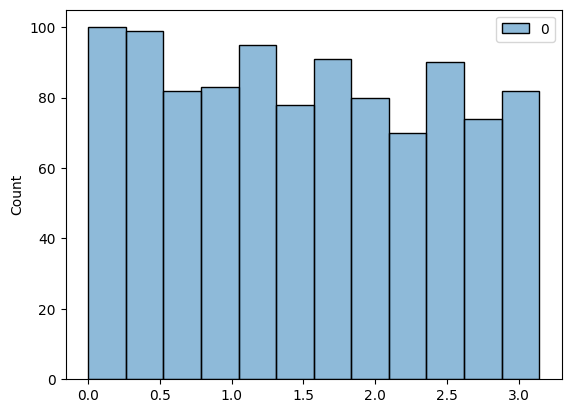

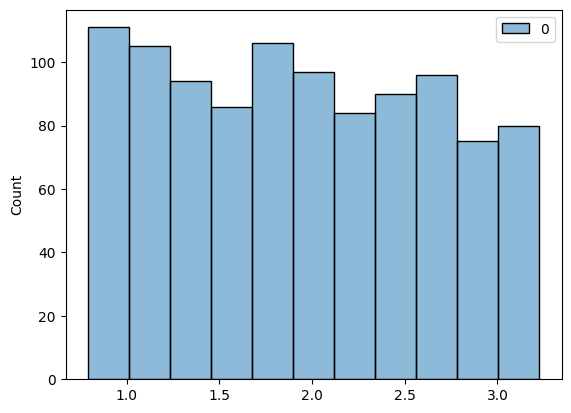

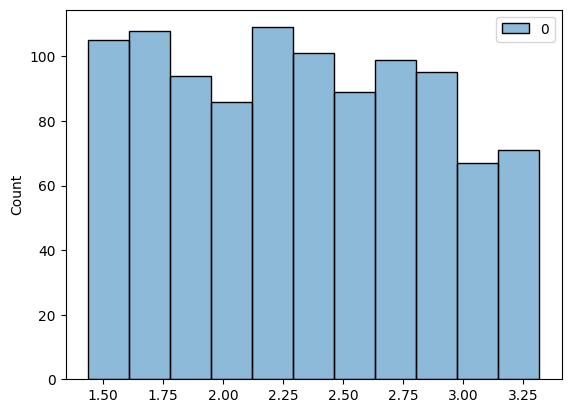

In [56]:
sns.histplot(traj[0].cpu().detach().numpy())
plt.figure()
sns.histplot(traj[50].cpu().detach().numpy())
plt.figure()
sns.histplot(traj[-1].cpu().detach().numpy())